In [91]:
import numpy as np
import matplotlib
import numpy as np
import scipy.stats as sst
import scipy as sp
import matplotlib.pylab as plt
from ipywidgets import interact,Checkbox,Text,VBox

import scipy.spatial.distance as ssp
import random

In [113]:
dx = 100
dy = dx

A = np.random.normal(70, 15, size=(50,50))
vector_A = A.flatten()
# print (A)

i_coords, j_coords = np.meshgrid(range(A.shape[0]), range(A.shape[1]), indexing='ij')
coords = np.column_stack((np.concatenate(i_coords), np.concatenate(j_coords)))
index = np.arange(A.shape[0]*A.shape[1])

In [115]:
unique = random.sample(range(A.shape[0]*A.shape[1]), 150)
data=vector_A[unique]
#Normalization of data
data = (data-np.mean(data))/np.std(data)
len_data = len(data)

(array([0.02229022, 0.03343533, 0.10030599, 0.3566435 , 0.32320818,
        0.42351416, 0.2340473 , 0.10030599, 0.06687066, 0.01114511]),
 array([-2.96998295, -2.37181327, -1.77364358, -1.17547389, -0.5773042 ,
         0.02086548,  0.61903517,  1.21720486,  1.81537454,  2.41354423,
         3.01171392]),
 <a list of 10 Patch objects>)

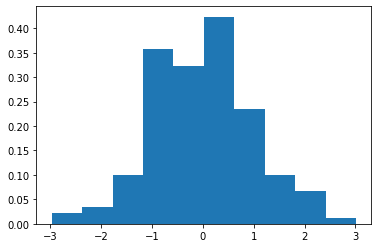

In [116]:
plt.hist(data, density=True)

(array([0.02777778, 0.11111111, 0.25694444, 0.43055556, 0.64583333,
        0.8125    , 0.94444444, 0.97222222, 0.99305556, 1.        ]),
 array([-2.39275467, -1.83637272, -1.27999077, -0.72360882, -0.16722687,
         0.38915508,  0.94553703,  1.50191898,  2.05830093,  2.61468288,
         3.17106483]),
 <a list of 10 Patch objects>)

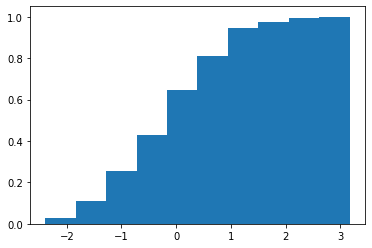

In [51]:
plt.hist(data, 
         density=True,
         cumulative=True)

In [52]:
#CORRECT!!!
coordinates_data = np.array([[i[0]*dx, i[1]*dy] for i in unique])


In [53]:
H = ssp.pdist(coordinates_data, metric='euclidean')
D = ssp.squareform(H)

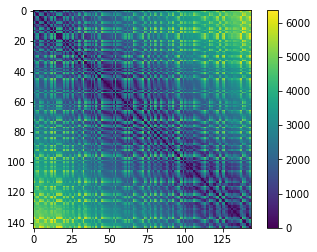

In [54]:
plt.imshow(D)
plt.colorbar()

Text(0.5, 1.0, 'Plan view')

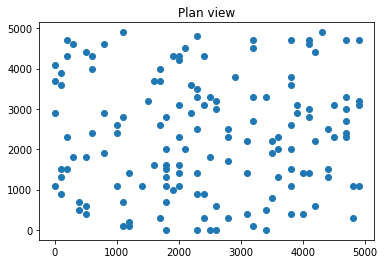

In [55]:
plt.scatter(coordinates_data[:,0], coordinates_data[:,1])
plt.title('Plan view')

In [56]:
var = np.zeros((len_data,len_data))
for i in range(len_data):
    for j in range(i, len_data):
        var[i,j] = (data[i] - data[j])**2.

Text(0, 0.5, 'variance')

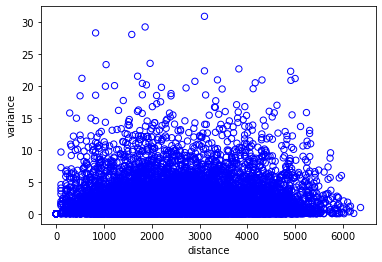

In [57]:
dists_ix = np.triu_indices(D.shape[0], 0)
dists_triu = D[dists_ix]

vars_ix = np.triu_indices(var.shape[0], 0)
vars_triu = var[vars_ix]

plt.scatter(dists_triu, vars_triu, s=40, facecolors='none', edgecolors='b')
plt.xlabel("distance")
plt.ylabel("variance")

In [66]:
bins = np.array([0.0, 250., 500., 1000., 2000., 3000., 4000., 5000., 6000.])

ixs = []    # for measurement values at point 0
ixs_h = []  # for measurement values at point 1
rs = []     # for rs in each bin
d_mean = [] # for mean distances

for cur_i in range(0, len(bins)-1):
    ix = np.where(np.logical_and(D>bins[cur_i], D<=bins[cur_i+1]))
    d_mean.append(D[ix].mean())
    F_0 = data[ix[0]]
    F_1 = data[ix[1]]
    r = np.corrcoef(F_0, F_1)[1,0]
    rs.append(r)
    ixs.append(F_0)
    ixs_h.append(F_1)  

Text(0.5, 1.0, 'Correlogram')

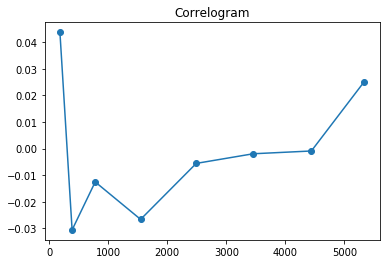

In [67]:
plt.plot(d_mean, rs, 'o-')
plt.title('Correlogram')

In [68]:
Z1, Z2 = np.meshgrid(data, data)
sem_var = (Z1-Z2)**2.


sem_vars = []
co_vars = []
for cur_i_bin, cur_bin in enumerate(bins[:-1]):
    ix = np.where(np.logical_and(D>bins[cur_i_bin], D<=bins[cur_i_bin+1]))
    
    ## do it via the prepared large matrices
    sem_var_cur = np.sum(sem_var[ix])/(2.0 * ix[0].shape[0])
    #print sem_var_cur
    sem_vars.append(sem_var_cur)
    
    mean = data[ix[1]].mean()
    covar = np.sum((data[ix[1]]-mean)* (data[ix[0]]-mean))/( ix[0].shape[0])
    co_vars.append(covar)

(0.0, 1.1765618519517793)

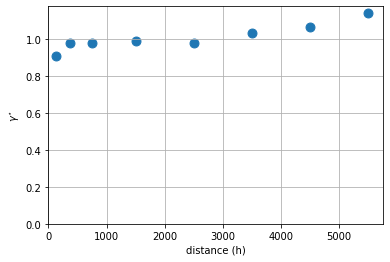

In [69]:
# Plot Empirical Variogram
centers =  (bins[:-1] + bins[1:])/2
plt.scatter(centers, np.array(sem_vars), s=80)
plt.grid(True)
plt.xlabel('distance (h)')
plt.ylabel('$\gamma^{\star}$')
plt.xlim(0.0,)
plt.ylim(0.0,)

In [62]:
import helpers.theo_variogram_fct as vario
import helpers.th_cov_func as nest_vario
# Define Dictionaries of Theoretical Variogram Models

# Dictionary for individual variogram models. Reference the theo_variogram_fct python file
models = {'Exponential': vario.ExponentialVariogram,
          'Spherical': vario.SphericalVariogram,
          'Gaussian': vario.GaussianVariogram,
          'Linear': vario.LinearVariogram}

# Dictionary for individual short-form variogram models to be used for composited variogram models
mods = {'Exp': vario.ExponentialVariogram,
        'Sph': vario.SphericalVariogram,
        'Gau': vario.GaussianVariogram,
        'Lin': vario.LinearVariogram}

In [63]:
# plotting for function for individual models
def plot_varmodel(Sill, Range, Model):
    v_model = Model(Sill, Range, h)
    plt.plot(h,v_model, c='red') # Model Variogram
    plt.scatter(centers, np.array(sem_vars), s=80) # Empirical Variogram
    plt.xlabel('distance')
    plt.ylabel('$\\gamma$')
    plt.xlim(0.,max(h))
    plt.ylim(0.,)
    plt.grid(True)
    plt.show()

In [64]:
# Determine first guess of sill and range from empirical variogram
var_sill = np.round(np.max(np.array(sem_vars)),decimals = -1)
h = np.linspace(0, max(centers),  int(max(centers)/10.))
var_range = np.round(np.max(np.array(centers)),decimals = -1)


In [65]:
# Trigger Interactive Plot
import importlib
importlib.reload(vario)
interact(plot_varmodel,
         Sill =(var_sill/2,var_sill*2,1),
         Range = (0,max(h), max(h)/100),
         Model = models)

interactive(children=(FloatSlider(value=0.0, description='Sill', max=0.0, step=1.0), FloatSlider(value=3250.0,…

<function __main__.plot_varmodel(Sill, Range, Model)>

In [73]:
(A.shape[0]*A.shape[1])-len(data)

2356

In [75]:
# coordinates = np.zeros(A.shape[0]*A.shape[1], 2)
x = range(50)
y = range(50)
coord = np.meshgrid(x,y)
coord 

[array([[ 0,  1,  2, ..., 47, 48, 49],
        [ 0,  1,  2, ..., 47, 48, 49],
        [ 0,  1,  2, ..., 47, 48, 49],
        ...,
        [ 0,  1,  2, ..., 47, 48, 49],
        [ 0,  1,  2, ..., 47, 48, 49],
        [ 0,  1,  2, ..., 47, 48, 49]]), array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 2,  2,  2, ...,  2,  2,  2],
        ...,
        [47, 47, 47, ..., 47, 47, 47],
        [48, 48, 48, ..., 48, 48, 48],
        [49, 49, 49, ..., 49, 49, 49]])]

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       ...,
       [49, 47],
       [49, 48],
       [49, 49]])

In [48]:
#Montecarlo random path
for i in n_realizations:
    


[-1.78125933  0.05972757 -0.4800176  -0.46260966 -1.89040292  0.38064255
  0.53729503  1.54480074 -0.03924333  2.03147046 -0.65126735 -0.71086501
  1.89404151 -0.14370159  1.54428885  0.45449424  0.57015946  1.11432525
 -0.47527175 -0.46506986  1.22774003 -0.52856536 -0.39184565 -0.76499951
 -0.76595211 -0.32533167  1.0252114  -0.13213358 -0.62219789 -0.697947
  0.78922236  0.46567459 -0.90792366  1.77853484 -1.21329505  0.03640543
 -0.97938268  0.27805267 -0.00562488 -0.71565826  2.15204188 -0.81605346
  0.13584998 -0.06993397  2.53571897  0.72679736 -1.04036653 -0.53308555
  0.26496802  0.16558603 -0.41402698  0.32672495  1.6884195  -0.17929022
 -0.16956501  0.65867071 -0.24394371  0.0515977  -2.0582677  -0.35825203
  0.06900967 -1.81235016  0.21270856  0.56399908 -0.4584084  -0.69739178
 -0.29808711  0.10272885 -0.03404132 -0.51014142  0.48408238 -1.26468974
  0.53954637  1.08425945  0.9728523   1.8333612  -0.04759784  0.51895314
  0.1021204  -1.01828474  2.43910571  0.80050067  0.0